In [33]:
import sys
import os

# Add the simulations/mcpy directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../simulations')))

import numpy as np
import pandas as pd

import ivfunctions_nested 
import simulations.dgps_nested as dgps
import matplotlib.pyplot as plt

from nnpiv.rkhs import RKHSIV, ApproxRKHSIVCV, RKHSIVCV, RKHSIVL2CV, RKHSIVL2, RKHS2IVL2CV, RKHSIVL2CV, RKHS2IVL2, RKHS2IV


 

In [34]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)

In [35]:
A, D, B, C, Y, tau_fn = dgps.get_data(2000, 10, 10, tau_fn, 2)


B_test = np.zeros((1000, B.shape[1]))
B_test += np.median(B, axis=0, keepdims=True)
B_test[:, 0] = np.linspace(np.percentile(B[:, 0], 5), np.percentile(B[:, 0], 95), 1000)

B_test = B_test[np.argsort(B_test[:, 0])]
true_fn = tau_fn(B_test)


In [36]:
def nested_npivfit(A, B, C, D, Y, B_test, model, fitargs=None):
    
    B1_test = B_test
    Y = Y
    A1 = A
    B1 = B
    A2 = D
    B2 = C

    #First stage
    if fitargs is not None:
        model.fit(A2, A1, Y, **fitargs)
    else:
        model.fit(A2, A1, Y)
    bridge_fs = model.predict(A1)
    bridge_fs = bridge_fs.reshape(A1.shape[:1] + Y.shape[1:])

    #Second stage
    if fitargs is not None:
        model.fit(B2, B1, bridge_fs, **fitargs)
    else:
        model.fit(B2, B1, bridge_fs)
    
    y_pred = model.predict(B1_test)
    return y_pred.reshape(B1_test.shape[:1] + Y.shape[1:])





In [37]:
approxrkhs_model = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=200,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5)

approxrkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=approxrkhs_model)



In [38]:
rkhs_model = RKHSIV(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4)
rkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhs_model)

In [39]:
rkhsl2_model = RKHSIVL2(kernel='rbf', gamma=.1, delta_scale='auto')
#rkhsl2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhsl2_model)

In [40]:
rkhs2l2_model = RKHS2IVL2(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4)
rkhs2l2_pred = rkhs2l2_model.fit(A, B, C, D, Y).predict(B_test)


In [41]:
rkhs2_model = RKHS2IV(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4)
rkhs2_pred = rkhs2_model.fit(A, B, C, D, Y).predict(B_test)


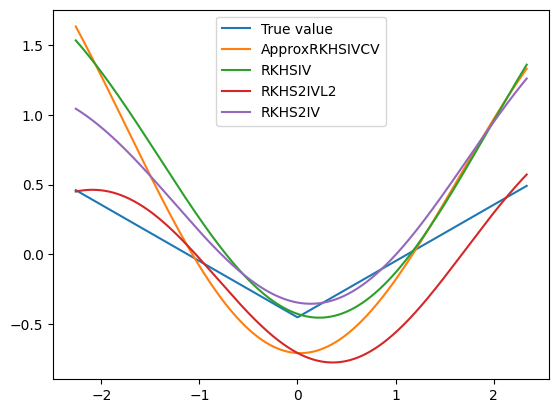

In [42]:
plt.plot(B_test[:, 0], true_fn, label='True value')
plt.plot(B_test[:, 0], approxrkhs_pred, label='ApproxRKHSIVCV')
plt.plot(B_test[:, 0], rkhs_pred, label='RKHSIV')
plt.plot(B_test[:, 0], rkhs2l2_pred, label='RKHS2IVL2')
#plt.plot(B_test[:, 0], rkhsl2_pred, label='RKHSIVL2')
plt.plot(B_test[:, 0], rkhs2_pred, label='RKHS2IV')
plt.legend()